## AI端到端

Data - Model - Optimize - Save - Infer

In [1]:
import mindspore  #导入mindspore AI框架
print(mindspore.__version__)  #打印mindspore版本号
import os 
# import moxing as mox #导入moxing网络模型开发API模块并简名为mox
import argparse # 参数-解析
from mindspore import context # 上下文 #导入mindspore子模块context，其下有set_context方法来配置运行需要的信息
parser = argparse.ArgumentParser(description="MindSpore LeNet Example")
parser.add_argument("--device_target" ,type=str ,default="CPU",choices=["Ascend","GPU","CPU"])
# print(parser)

args = parser.parse_known_args()[0] # 需要训练
print(args)
context.set_context(mode = context.GRAPH_MODE,device_target = args.device_target) #通过set_context方法配置，mode设置运行模式(动态图模式)，用CPU运行

1.6.1
Namespace(device_target='CPU')


运行使用图模式
根据需求选择运行设备

运行如下处理以获取数据集（建议使用mobaxterm打开一个terminal,jupyter不能运行）

mkdir -p ./datasets/MNIST_Data/train ./datasets/MNIST_Data/test
wget -NP ./datasets/MNIST_Data/train https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-labels-idx1-ubyte
wget -NP ./datasets/MNIST_Data/train https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-images-idx3-ubyte
wget -NP ./datasets/MNIST_Data/test https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-labels-idx1-ubyte
wget -NP ./datasets/MNIST_Data/test https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-images-idx3-ubyte
tree ./datasets/MNIST_Data

## 数据处理
mindspore.dataset中定义了许多方法


In [2]:
import mindspore.dataset as ds  # 导入mindspore子数据集模块，这个API模块用于数据处理主，存储样本和标签，同时也集成了一些常见的数据处理方法。
import mindspore.dataset.transforms.c_transforms as C # 导入MindSpore提供的支持常见的图形增强功能的模块对图像进行预处理，简名为C
import mindspore.dataset.vision.c_transforms as CV # 导入MindSpore提供的增强数据集模块对图像进行预处理，从而提高模型的广泛性，简名为CV
from mindspore.dataset.vision import Inter # 导入MindSpore提供的vision子模块可以调整图像大小
from mindspore import dtype as mstype  # 导入数据类型转换处理模块 定义为mindspore的数据类型

数据集的处理分为四个阶段：
 - 定义`create_dataset`来创建数据集
 - 定义需要进行的数据增强和处理操作 为之后map映射做准备
 - 使用map映射函数，将数据操作应用到数据集
 - 进行数据shuffle batch等操作

In [3]:
def create_dataset(data_path,batch_size = 32, repeat_size = 1, num_parallel_workers = 1):
    # 定义数据集
    # mnist_ds = ds.MindDataset(data_path) #定义数据集
    mnist_ds = ds.MnistDataset(data_path) #定义数据集
    resize_height,resize_width = 32,32 #设置图像变量高与宽
    
    # 无偏移的标准化操作参数
    rescale = 1.0/255.0
    shift = 0.0 
    
    # 带偏移的标准化操作参数
    rescale_nml = 1/0.3801
    shift_nml = -1*0.1307/0.3081
    
    # * 定义需要进行的数据增强和处理操作，为之后进行map映射做准备
    
    resize_op = CV.Resize((resize_height,resize_width),interpolation=Inter.LINEAR) #缩小或者放大函数至预定高与宽，指定像素插值方式为双线性插值
    
    # 带偏移的标准化、归一化操作
    rescale_nml_op = CV.Rescale(rescale_nml,shift_nml) # with: output = image * rescale + shift.    
    # 对图像数据进行标准化、归一化操作，使得每个像素的数值大小在（0,1）范围中，可以提升训练效率，shift增加偏移量
    rescale_op = CV.Rescale(rescale ,shift) 
    hwc2chw_op = CV.HWC2CHW()# 对图像数据张量进行变换，张量形式由高x宽x通道（HWC）变为通道x高x宽（CHW），方便进行数据训练。
    type_cast_op = C.TypeCast(mstype.int32)#  将数据类型转化为int32
    
    # * 使用map映射函数，将数据操作应用到数据集
    mnist_ds = mnist_ds.map(operations=type_cast_op,input_columns="label",num_parallel_workers=num_parallel_workers)  #应用到数据集操作方法 数据类型转换，操作列为标签列，并行一接口计算
    mnist_ds = mnist_ds.map(operations=resize_op,input_columns="image",num_parallel_workers=num_parallel_workers)     #应用到数据集操作方法 对图像放大缩小处理，预备插值，操作列为图像列，并行一接口计算
    mnist_ds = mnist_ds.map(operations=rescale_op,input_columns="image",num_parallel_workers=num_parallel_workers)    #应用到数据集操作方法 编译文件标准化归一化，操作列为图象列，并行一接口计算
    mnist_ds = mnist_ds.map(operations=rescale_nml_op,input_columns="image",num_parallel_workers=num_parallel_workers)#应用到数据集操作方法 编译文件标准化归一化，操作列为图象列，并行一接口计算
    mnist_ds = mnist_ds.map(operations=hwc2chw_op,input_columns="image",num_parallel_workers=num_parallel_workers)    #应用到数据集操作方法 张量进行变换，操作列为图象列，并行一接口计算
    
    # * 进行shuffle、batch操作
    buffer_size = 10000
    mnist_ds=mnist_ds.shuffle(buffer_size=buffer_size) #先进行shuffle、batch操作，再进行repeat操作，这样能保证1个epoch内数据不重复

    # 将整个数据集按照batch_size的大小分为若干批次，每一次训练的时候都是按一个批次的数据进行训练，
    # drop_remainder确定是否删除数据行数小于批大小的最后一个块，这里设置为True就是只保留数据集个数整除
    mnist_ds=mnist_ds.batch(batch_size=batch_size,drop_remainder=True) 
    
    mnist_ds = mnist_ds.repeat(repeat_size)  #将数据集重复repeat_size次，注意该操作一般使用在batch操作之后
    
    return mnist_ds  
    

In [4]:
create_dataset(data_path= "./datasets/MNIST_Data/train")

## 创建模型
使用mindspore创建模型需要继承`mindspore.nn.Cell` Cell是(covn2d-relu-softmax)等的基类

网络的各层在`__init__`中定义，然后通过定义`construct`方法来完成模型的前向构造

![](1651281990000.png)

根据LeNet的网络结构 定义网络各层如下

In [5]:
import mindspore.nn as nn  # 创建模型，配置网络结构（卷积，压平，全连接，激活函数，最大池化），导入nn子模块简名为nn
from mindspore.common.initializer import Normal # 导入Normal模块类配置初始权重（正态分布）

class LeNet5(nn.Cell):  #定义LeNet5类并继承nn.Cell类的属性和方法
    def __init__(self,num_class = 10,num_channel = 1):
        super(LeNet5,self).__init__()   #声明继承父类nn.cell的__init__方法
        #定义需要的运算
        
        # * nn.Conv2d的第一个参数是输入图片的通道数为1，即单个过滤器应有的通道数，
        # 第二个参数是输出图片的通道数，第三个参数是过滤器的二维属性，
        # 它可以是一个int元组，但由于一般过滤器都是a * a形式的，而且为奇数。所以这里填入单个数即可
        # 参数pad_mode为卷积方式，valid卷积即padding为0的卷积
        # 现在也比较流行same卷积，即卷积后输出的图片不会缩小。
        # 需要注意的是卷积层我们是不需要设置参数的随机方式的，因为它默认会给我们选择为Noremal
        self.conv1 = nn.Conv2d(num_channel,6,5,pad_mode='valid')
        self.conv2 = nn.Conv2d(6,16,5,pad_mode='valid')
        
        # * nn.Dense为致密连接层
        # 它的第一个参数为输入层的维度，第二个参数为输出的维度，
        # 第三个参数为神经网络可训练参数W权重矩阵的初始化方式，默认为normal，以上代码对号入座即可
        self.fc1 = nn.Dense(16*5*5,120,weight_init = Normal(0.02))
        self.fc2 = nn.Dense(120,84,weight_init = Normal(0.02))
        self.fc3 = nn.Dense(84,num_class,weight_init = Normal(0.02))
        self.relu = nn.ReLU()   # * nn.ReLU()非线性激活函数，它往往比论文中的sigmoid激活函数具有更好的效益
        self.max_pool2d = nn.MaxPool2d(kernel_size=2,stride=2)  # * nn.MaxPool2d为最大池化层的定义，kernel_size为采样器的大小，stride为采样步长，本例中将其都设置为2相当于将图片的宽度和高度都缩小一半
        self.flatten = nn.Flatten()  # * nn.Flatten为输入展成平图层，即去掉那些空的维度
        
    def construct(self,x):
        # 构建前向网络
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)      
        return x
    
net = LeNet5()
# print(net)


## 定义超参
lr = learning_rate 学习率

momentum = [动量方法避免局部最优化](https://blog.csdn.net/weixin_43687366/article/details/108214854)

In [6]:
lr = 0.01 #learingrate,学习率，可以使梯度下降的幅度变小，从而可以更好的训练参数
momentum = 0.9
epoch_size = 1 # 每个epoch(代、时代)需要遍历完成图片的bacth(批次、批量)数一次

## 优化模型参数
要训练神经网络模型，需要你定义损失函数和优化器

MindSpore支持的
- 损失函数  => [常见](https://zhuanlan.zhihu.com/p/401010037)
  - [`SoftMaxCrossEntropyWithLogits`](https://zhuanlan.zhihu.com/p/51431626)
  - `L1Loss`
  - `MSELoss`
- 优化器
  - `Adam`
  - `AdamWeightDecay`
  - `Momentum`

In [7]:
#损失函数：又叫目标函数，用于衡量预测值与实际值差异的程度。
# 深度学习通过不停地迭代来缩小损失函数的值。
# 定义一个好的损失函数，可以有效提高模型的性能。
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True,reduction='mean') # 损失函数 
#相当于softmax分类器
#sparse指定标签（label）是否使用稀疏模式，默认为false,reduction为损失的减少类型：mean表示平均值，一般
#情况下都是选择平均地减少

#优化器
net_opt = nn.Momentum(net.trainable_params(),learning_rate=lr,momentum=0.9)  # 其中grad、lr、p、v和u分别表示梯度、学习率、参数、力矩和动量。

## 训练及保存模型
mindspore的callback 可以在训练的时候执行自定义逻辑

使用`ModelCheckPoint`为例

可以保存网络模型和参数

以便后续进行 Fine-tuning (微调) 操作


In [8]:
from mindspore.train.callback import ModelCheckpoint,CheckpointConfig
# 设置模型保存参数
model_save_path = "./model/LeNet5/ckpt/"

config_ck = CheckpointConfig(save_checkpoint_steps=125,keep_checkpoint_max=10)
# 应用模型保存参数
ckpoint = ModelCheckpoint(prefix="lenet5", directory = model_save_path, config=config_ck)


通过使用 mindspore 提供的`model.train` 接口可以方便地进行网络的训练

`LossMonitor`可以监控训练过程中`loss`值的变化

In [9]:
from mindspore.nn import Accuracy
from mindspore.train.callback import LossMonitor
from mindspore import Model

In [10]:
def train_net(args, model:Model, epoch_size, data_path, repeat_size, ckpoint_cb, sink_mode):
    """定义训练的方法"""
    # DATA_DIR = "./datasets/MNIST_Data/train"
    ds_train = create_dataset(os.path.join(data_path,"train"), 32, repeat_size)
    # ds_train = create_dataset(DATA_DIR, 32, repeat_size)
    
    # 调用Model类的train方法进行训练，LossMonitor(125)每隔125个step打印训练过程中的loss值 
    # dataset_sink_mode为设置数据下沉模式，但该模式不支持CPU，所以这里我们只能设置为False
    model.train(epoch_size, ds_train, callbacks=[ckpoint_cb,LossMonitor(125)],dataset_sink_mode = sink_mode) 

其中 dataset_sink_mode 用于控制数据是否下沉

数据下沉是指数据通过通道直接传送Device上 可以加快训练速度 True表示下沉 否则非下沉（非Ascend设备好像不能下沉）

通过模型运行测试数据接得到的结果可以验证模型的泛化能力

In [11]:
def test_net(network:nn.Cell, model:Model, data_path):
    DATA_TEST = "./datasets/MNIST_Data/test"
    ds_eval = create_dataset(os.path.join(data_path,"test"))
    # ds_eval = create_dataset(DATA_TEST)
    acc = model.eval(ds_eval,dataset_sink_mode=False)
    print("{}".format(acc))

## 执行流程
设置使用的文件名、训练控制变量

`train_epoch`设置为1 进行一个迭代的训练

在`train_net`和`test_net`方法中我们加载之前下载的数据集

`data_path` 是 MNIST 数据集的路径

In [12]:
train_epoch = 1
# 路径
data_path = "./datasets/MNIST_Data"

# os.system('rm -f {}*.ckpt {}*.meta {}*.pb'.format(model_path, model_path, model_path)) # 移除先前的ckpt等files linux下是这样
# os.remove(model_save_path[:-1]) # 移除先前的ckpt等files jupyter 实现不了

dataset_size = 1

model = Model(net, net_loss, net_opt, metrics={"Accuary":Accuracy()})
# 训练网络
train_net(args=args, model=model, epoch_size=train_epoch, data_path=data_path, repeat_size=dataset_size, ckpoint_cb=ckpoint,sink_mode=False)

# 验证网络
test_net(network=net, model=model, data_path=data_path)

epoch: 1 step: 125, loss is 2.303574800491333
epoch: 1 step: 250, loss is 2.2980284690856934
epoch: 1 step: 375, loss is 2.3059816360473633
epoch: 1 step: 500, loss is 2.3096466064453125
epoch: 1 step: 625, loss is 2.309044361114502
epoch: 1 step: 750, loss is 2.2958693504333496
epoch: 1 step: 875, loss is 1.689231038093567
epoch: 1 step: 1000, loss is 0.7370644211769104
epoch: 1 step: 1125, loss is 0.37256941199302673
epoch: 1 step: 1250, loss is 0.20879177749156952
epoch: 1 step: 1375, loss is 0.12545432150363922
epoch: 1 step: 1500, loss is 0.14776207506656647
epoch: 1 step: 1625, loss is 0.2144518941640854
epoch: 1 step: 1750, loss is 0.037226323038339615
epoch: 1 step: 1875, loss is 0.10260177403688431
{'Accuary': 0.9489182692307693}


## 加载模型

In [14]:
from mindspore.train.serialization import load_checkpoint, load_param_into_net
# 加载已经保存的模型
param_dict = load_checkpoint("./model/LeNet5/ckpt/lenet5_1-1_1750.ckpt")
# 加载参数到网络中
load_param_into_net(net=net, parameter_dict= param_dict)

[]

## 验证模型
使用生成的模型进行单个图片的分类于此，具体步骤如下：

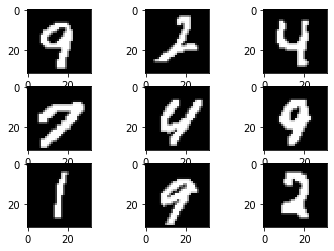

Predicted: [9 2 4 7 4 9 1 9 2]
Actual: [9 2 4 7 4 9 1 9 2]


In [16]:
import numpy as np
from mindspore import Tensor
import matplotlib.pyplot as plt

# 加载验证集并创建可迭代对象 data就包含了一组（6个）用于测试的图像
ds_test = create_dataset(os.path.join(data_path, "test"),batch_size=9).create_dict_iterator()
data = next(ds_test)

# images 为测试图片 ，label为实际分类
images = data["image"].asnumpy()
labels = data["label"].asnumpy()
plt.figure()
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(images[i-1][0], interpolation='None', cmap='gray')
plt.show()

# 使用函数 model.predict 预测对应的分类
output = model.predict(Tensor(data['image']))
predicted = np.argmax(output.asnumpy(),axis=1)

print("Predicted: {}".format(predicted))
print("Actual: {}".format(labels))